# 🎧 Skip Prediction Dataset: Exploration  
**Project:** Skip Song Prediction (SQL + ML)  
**Author:** Nadine Daum  

This notebook explores the synthetic streaming dataset using Python + DuckDB.  
We analyze user behavior, track properties, and skip patterns to understand the structure of real-world music recommendation data.


In [1]:
from pathlib import Path
import duckdb
import pandas as pd

# Detect project root automatically
project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent

# Build path to dataset
data_path = project_root / "data" / "synthetic_sessions.csv"
print("Project root:", project_root)
print("Using data:", data_path)

# Load data
df = duckdb.read_csv(data_path.as_posix()).df()
df.head()


Project root: /Users/GitHub 2025/skip-song-prediction
Using data: /Users/GitHub 2025/skip-song-prediction/data/synthetic_sessions.csv


,session_id,user_id,position,time_of_day,day_type,location,track_id,age_group,gender,country,...,skip_tendency,genre,popularity,acousticness,danceability,energy,tempo,duration_sec,skip_prob,skip
0,1,1067,1,afternoon,weekend,work,2575,18-24,female,LATAM,...,high,electronic,35,0.721350,0.911924,0.490107,147,182,0.63,True
1,1,1067,2,afternoon,weekend,work,1418,18-24,female,LATAM,...,high,hiphop,85,0.038647,0.263042,0.396802,146,335,0.68,False
2,1,1067,3,afternoon,weekend,work,4203,18-24,female,LATAM,...,high,hiphop,1,0.575145,0.408896,0.433143,94,124,0.68,True
3,1,1067,4,afternoon,weekend,work,3896,18-24,female,LATAM,...,high,latin,21,0.538074,0.584303,0.219636,151,174,0.68,True
4,1,1067,5,afternoon,weekend,work,3797,18-24,female,LATAM,...,high,pop,90,0.391184,0.158876,0.016937,176,334,0.68,True


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438834 entries, 0 to 438833
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   session_id     438834 non-null  int64  
 1   user_id        438834 non-null  int64  
 2   position       438834 non-null  int64  
 3   time_of_day    438834 non-null  object 
 4   day_type       438834 non-null  object 
 5   location       438834 non-null  object 
 6   track_id       438834 non-null  int64  
 7   age_group      438834 non-null  object 
 8   gender         438834 non-null  object 
 9   country        438834 non-null  object 
 10  subscription   438834 non-null  object 
 11  platform       438834 non-null  object 
 12  skip_tendency  438834 non-null  object 
 13  genre          438834 non-null  object 
 14  popularity     438834 non-null  int64  
 15  acousticness   438834 non-null  float64
 16  danceability   438834 non-null  float64
 17  energy         438834 non-nul

In [3]:
import duckdb
duckdb.register("df", df)

duckdb.sql("""
SELECT
    COUNT(*) AS total_events,
    COUNT(DISTINCT user_id) AS n_users,
    COUNT(DISTINCT track_id) AS n_tracks,
    COUNT(DISTINCT session_id) AS n_sessions
FROM df
""").df()


,total_events,n_users,n_tracks,n_sessions
0,438834,2000,5000,20000


In [4]:
duckdb.sql("SELECT * FROM df LIMIT 5").df()

,session_id,user_id,position,time_of_day,day_type,location,track_id,age_group,gender,country,...,skip_tendency,genre,popularity,acousticness,danceability,energy,tempo,duration_sec,skip_prob,skip
0,1,1067,1,afternoon,weekend,work,2575,18-24,female,LATAM,...,high,electronic,35,0.721350,0.911924,0.490107,147,182,0.63,True
1,1,1067,2,afternoon,weekend,work,1418,18-24,female,LATAM,...,high,hiphop,85,0.038647,0.263042,0.396802,146,335,0.68,False
2,1,1067,3,afternoon,weekend,work,4203,18-24,female,LATAM,...,high,hiphop,1,0.575145,0.408896,0.433143,94,124,0.68,True
3,1,1067,4,afternoon,weekend,work,3896,18-24,female,LATAM,...,high,latin,21,0.538074,0.584303,0.219636,151,174,0.68,True
4,1,1067,5,afternoon,weekend,work,3797,18-24,female,LATAM,...,high,pop,90,0.391184,0.158876,0.016937,176,334,0.68,True


In [5]:
duckdb.sql("""
SELECT AVG(CASE WHEN skip THEN 1 ELSE 0 END) AS skip_rate
FROM df
""").df()

,skip_rate
0,0.415754


In [6]:
duckdb.sql("""
SELECT country,
       AVG(CASE WHEN skip THEN 1 ELSE 0 END) AS skip_rate,
       COUNT(*) AS events
FROM df
GROUP BY country
ORDER BY skip_rate DESC
""").df()


,country,skip_rate,events
0,LATAM,0.504083,86573
1,AFRICA,0.426960,18264
2,ASIA,0.410816,85223
3,NA,0.409948,93302
4,EU_UK,0.371443,155472


In [7]:
duckdb.sql("""
SELECT 
    age_group,
    AVG(CASE WHEN skip THEN 1 ELSE 0 END) AS skip_rate,
    COUNT(*) AS events
FROM df
GROUP BY age_group
ORDER BY 
    CASE age_group
        WHEN '13-17' THEN 1
        WHEN '18-24' THEN 2
        WHEN '25-34' THEN 3
        WHEN '35-44' THEN 4
        WHEN '45+' THEN 5
    END
""").df()


,age_group,skip_rate,events
0,13-17,0.435855,40720
1,18-24,0.449777,155468
2,25-34,0.391725,127342
3,35-44,0.386313,69907
4,45+,0.393947,45397


In [8]:
duckdb.sql("""
SELECT 
    position,
    AVG(CASE WHEN skip THEN 1 ELSE 0 END) AS skip_rate,
    COUNT(*) AS events
FROM df
GROUP BY position
ORDER BY position
""").df()


,position,skip_rate,events
0,1,0.414950,20000
1,2,0.416950,20000
2,3,0.413650,20000
3,4,0.412550,20000
4,5,0.417000,20000
5,6,0.412611,19396
6,7,0.421768,18835
7,8,0.413697,18238
8,9,0.414207,17682
9,10,0.417787,17102


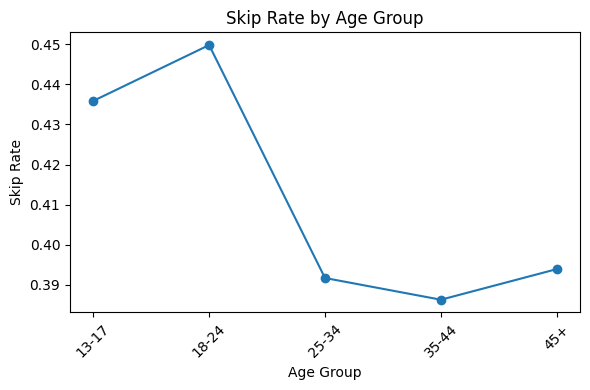

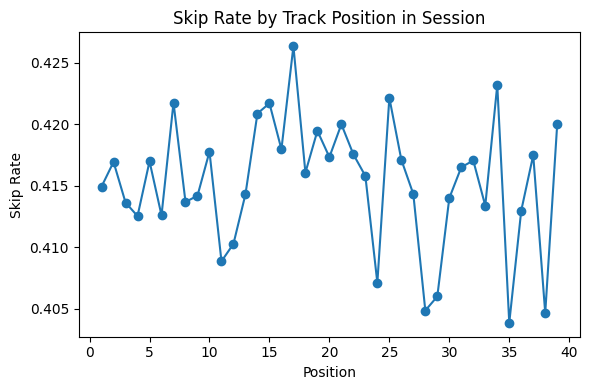

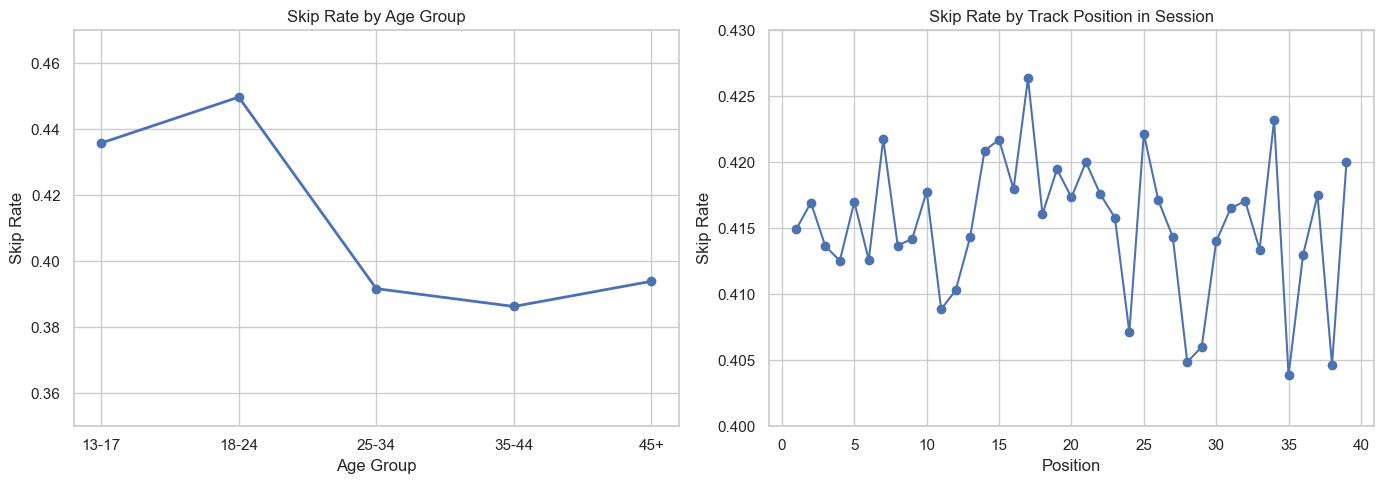

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# --- AGE GROUP SKIP RATE ---
age_df = (
    df.groupby("age_group")["skip"]
      .mean()
      .reindex(["13-17", "18-24", "25-34", "35-44", "45+"])
      .reset_index()
)

plt.figure(figsize=(6,4))
plt.plot(age_df["age_group"], age_df["skip"], marker="o")
plt.title("Skip Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Skip Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- SESSION POSITION SKIP RATE ---
pos_df = df.groupby("position")["skip"].mean().reset_index()

plt.figure(figsize=(6,4))
plt.plot(pos_df["position"], pos_df["skip"], marker="o")
plt.title("Skip Rate by Track Position in Session")
plt.xlabel("Position")
plt.ylabel("Skip Rate")
plt.tight_layout()
plt.show()


# Use a nice style
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- AGE GROUP PLOT ---
age_df = (
    df.groupby("age_group")["skip"]
    .mean()
    .reindex(["13-17", "18-24", "25-34", "35-44", "45+"])
    .reset_index()
)

axes[0].plot(age_df["age_group"], age_df["skip"], marker="o", linewidth=2)
axes[0].set_title("Skip Rate by Age Group")
axes[0].set_xlabel("Age Group")
axes[0].set_ylabel("Skip Rate")
axes[0].set_ylim(0.35, 0.47)

# --- POSITION PLOT ---
pos_df = (
    df.groupby("position")["skip"]
    .mean()
    .reset_index()
)

axes[1].plot(pos_df["position"], pos_df["skip"], marker="o", linewidth=1.5)
axes[1].set_title("Skip Rate by Track Position in Session")
axes[1].set_xlabel("Position")
axes[1].set_ylabel("Skip Rate")
axes[1].set_ylim(0.40, 0.43)

plt.tight_layout()
plt.show()


In [10]:
duckdb.sql("""
SELECT time_of_day,
       AVG(CASE WHEN skip THEN 1 ELSE 0 END) AS skip_rate,
       COUNT(*) AS events
FROM df
GROUP BY time_of_day
ORDER BY skip_rate DESC
""").df()


,time_of_day,skip_rate,events
0,night,0.428322,66380
1,afternoon,0.425887,153947
2,evening,0.423009,131898
3,morning,0.377062,86609


In [11]:
duckdb.sql("""
SELECT genre,
       AVG(CASE WHEN skip THEN 1 ELSE 0 END) AS skip_rate,
       COUNT(*) AS events
FROM df
GROUP BY genre
ORDER BY skip_rate DESC
""").df()


,genre,skip_rate,events
0,jazz,0.521767,12588
1,classical,0.519667,22118
2,rock,0.427642,69965
3,electronic,0.426427,62299
4,indie,0.426006,31739
5,hiphop,0.422065,86245
6,latin,0.378253,44465
7,pop,0.376164,109415


In [12]:
duckdb.sql("""
SELECT subscription,
       AVG(CASE WHEN skip THEN 1 ELSE 0 END) AS skip_rate,
       COUNT(*) AS events
FROM df
GROUP BY subscription
ORDER BY skip_rate DESC
""").df()


,subscription,skip_rate,events
0,free,0.466600,198575
1,student,0.385148,45180
2,family,0.377254,40816
3,premium,0.369453,154263


In [13]:
duckdb.sql("""
SELECT platform,
       AVG(CASE WHEN skip THEN 1 ELSE 0 END) AS skip_rate,
       COUNT(*) AS events
FROM df
GROUP BY platform
ORDER BY skip_rate DESC
""").df()


,platform,skip_rate,events
0,ios,0.418147,178626
1,android,0.417589,177421
2,web,0.413651,22797
3,desktop,0.404001,59990


In [14]:
duckdb.sql("""
SELECT day_type,
       AVG(CASE WHEN skip THEN 1 ELSE 0 END) AS skip_rate
FROM df
GROUP BY day_type
""").df()


,day_type,skip_rate
0,weekday,0.400516
1,weekend,0.452388


In [15]:
import plotly.express as px

# compute skip rate by age
age_df = (
    df.groupby("age_group")["skip"]
      .mean()
      .reindex(["13-17", "18-24", "25-34", "35-44", "45+"])
      .reset_index()
)

fig = px.line(
    age_df,
    x="age_group",
    y="skip",
    markers=True,
    title="Interactive Skip Rate by Age Group",
    labels={"skip": "Skip Rate", "age_group": "Age Group"},
)

fig.update_layout(
    template="plotly_white",
    title_x=0.5,
    yaxis=dict(tickformat=".2%"),
    hoverlabel=dict(bgcolor="black", font_color="white")
)

fig.show()


In [16]:
import plotly.express as px

pos_df = (
    df.groupby("position")["skip"]
      .mean()
      .reset_index()
)

fig = px.line(
    pos_df,
    x="position",
    y="skip",
    markers=True,
    title="Interactive Skip Rate by Track Position in Session",
    labels={"skip": "Skip Rate", "position": "Track Position"},
)

fig.update_layout(
    template="plotly_white",
    title_x=0.5,
    hoverlabel=dict(bgcolor="black", font_color="white"),
    xaxis=dict(dtick=2)
)

fig.show()


In [17]:
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

# --- AGE GROUP ---
age_df = (
    df.groupby("age_group")["skip"]
      .mean()
      .reset_index()
)

# --- POSITION ---
pos_df = (
    df.groupby("position")["skip"]
      .mean()
      .reset_index()
)

# --- TIME OF DAY ---
tod_df = (
    df.groupby("time_of_day")["skip"]
      .mean()
      .reset_index()
)

# --- GENRE ---
genre_df = (
    df.groupby("genre")["skip"]
      .mean()
      .reset_index()
      .sort_values("skip", ascending=False)
)


In [18]:
fig = sp.make_subplots(
    rows=2, cols=2,
    subplot_titles=[
        "Skip Rate by Age Group",
        "Skip Rate by Track Position",
        "Skip Rate by Time of Day",
        "Skip Rate by Genre"
    ]
)


In [19]:
fig.add_trace(
    go.Scatter(
        x=age_df["age_group"],
        y=age_df["skip"],
        mode="lines+markers",
        name="Age Group"
    ),
    row=1, col=1
)


fig.add_trace(
    go.Scatter(
        x=pos_df["position"],
        y=pos_df["skip"],
        mode="lines+markers",
        name="Track Position"
    ),
    row=1, col=2
)


In [20]:
fig.add_trace(
    go.Bar(
        x=tod_df["time_of_day"],
        y=tod_df["skip"],
        name="Time of Day"
    ),
    row=2, col=1
)


In [21]:
fig.add_trace(
    go.Bar(
        x=genre_df["genre"],
        y=genre_df["skip"],
        name="Genre"
    ),
    row=2, col=2
)


In [22]:
import plotly.graph_objects as go

overall_skip_rate = df["skip"].mean()

fig_kpi = go.Figure()

fig_kpi.add_trace(go.Indicator(
    mode="number+gauge+delta",
    value=overall_skip_rate * 100,
    number={'suffix': "%", 'valueformat': ".2f"},
    title={'text': "Overall Skip Rate"},
    gauge={
        'axis': {'range': [0, 100]},
        'bar': {'color': 'royalblue'},
        'steps': [
            {"range": [0, 30], "color": "#E8F1FD"},
            {"range": [30, 45], "color": "#C6DBF8"},
            {"range": [45, 60], "color": "#9EC2F1"},
        ],
    }
))

fig_kpi.update_layout(
    height=250,
    width=600,
    template="plotly_white",
    margin=dict(t=40, b=20)
)

fig_kpi.show()


In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- KPI ---
overall_skip_rate = df["skip"].mean() * 100

# --- Prepare aggregated data ---
age_df = df.groupby("age_group")["skip"].mean().reset_index()
pos_df = df.groupby("position")["skip"].mean().reset_index()
tod_df = df.groupby("time_of_day")["skip"].mean().reset_index()
genre_df = df.groupby("genre")["skip"].mean().reset_index()

# --- Create Subplots Grid ---
fig = make_subplots(
    rows=2, cols=3,
    specs=[
        [{"type": "indicator"}, {"type": "scatter"}, {"type": "bar"}],
        [{"type": "bar"}, {"type": "bar"}, {"type": "bar"}]
    ],
    subplot_titles=[
        "Overall Skip Rate",
        "Skip Rate by Age Group",
        "Skip Rate by Track Position",
        "Skip Rate by Time of Day",
        "Skip Rate by Genre",
        ""
    ]
)

# === KPI (Row 1, Col 1) ===
fig.add_trace(
    go.Indicator(
        mode="gauge+number",
        value=overall_skip_rate,
        number={"suffix": "%", "valueformat": ".2f"},
        gauge={
            "axis": {"range": [0, 100]},
            "bar": {"color": "royalblue"},
            "steps": [
                {"range": [0, 30], "color": "#E8F1FD"},
                {"range": [30, 45], "color": "#C6D8FB"},
                {"range": [45, 100], "color": "#99C2F1"},
            ],
        },
    ),
    row=1, col=1
)

# === Age Group Line ===
fig.add_trace(
    go.Scatter(
        x=age_df["age_group"],
        y=age_df["skip"],
        mode="lines+markers",
        line=dict(width=3, color="royalblue"),
        marker=dict(size=8)
    ),
    row=1, col=2
)

# === Track Position ===
fig.add_trace(
    go.Scatter(
        x=pos_df["position"],
        y=pos_df["skip"],
        mode="lines+markers",
        line=dict(width=2, color="mediumseagreen"),
    ),
    row=1, col=3
)

# === Time of Day ===
fig.add_trace(
    go.Bar(
        x=tod_df["time_of_day"],
        y=tod_df["skip"],
        marker_color="tomato"
    ),
    row=2, col=1
)

# === Genre ===
fig.add_trace(
    go.Bar(
        x=genre_df["genre"],
        y=genre_df["skip"],
        marker_color="turquoise"
    ),
    row=2, col=2
)

# --- Final Layout ---
fig.update_layout(
    height=900,
    width=1600,
    template="plotly_white",
    title_text="🎧 Skip Behavior Dashboard (Interactive)",
    showlegend=False,
    margin=dict(t=50)
)

fig.show()
